### Capitulo 7: Métodos Ensemble:
A combinação de diferentes classificadores a fim de obter um classificador melhor que o melhor deles.

#### 1. Voting
simplesmente treina diferentes classificadores e vota, com peso 1 (hard voting), ou considerando a probabilidade da classe (soft voting).

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

random_seed = 1

log_clf = LogisticRegression(random_state=random_seed)
tree1_clf = DecisionTreeClassifier(min_samples_leaf=8, random_state=random_seed)
tree2_clf = DecisionTreeClassifier(max_depth=3, random_state=random_seed)

#pega os dados
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

#train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.5, random_state=random_seed)

voting_clf = VotingClassifier(
estimators = [('lr', log_clf),('tree1', tree1_clf),('tree2',tree2_clf)],
voting = 'hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)),
                             ('tree1',
                              DecisionTreeClassifier(min_samples_leaf=8,
                                                     random_state=1)),
                             ('tree2',
                              DecisionTreeClassifier(max_depth=3,
                                                     random_state=1))])

In [3]:
#verificar a acurácia
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree1_clf, tree2_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.9052631578947369
DecisionTreeClassifier 0.8947368421052632
DecisionTreeClassifier 0.9087719298245615
VotingClassifier 0.9263157894736842


Vejamos se melhora com soft voting.

In [4]:

soft_voting_clf = VotingClassifier(
estimators = [('lr', log_clf),('tree1', tree1_clf),('tree2',tree2_clf)],
voting = 'soft'
)
soft_voting_clf.fit(X_train, y_train)
y_pred = soft_voting_clf.predict(X_val)
print(soft_voting_clf.__class__.__name__, accuracy_score(y_val, y_pred))

VotingClassifier 0.9228070175438596


#### 2. Bagging e Pasting
Aqui usamos um mesmo estimador mas com técnicas de reamostragem para gerar diferentes classificadores. Se usamos com substituição então fazemos um Bootstraping agregation ( daí bagging). Sem substituição se chama pasting. 

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier (
DecisionTreeClassifier(), n_estimators = 500,
max_samples = 60, bootstrap=True, n_jobs = -1, oob_score=True, random_state=random_seed)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(bag_clf.oob_score_)

0.9192982456140351
0.9471830985915493


Vejamos quanto uma decision tree chegaria:

In [6]:
tree_clf = DecisionTreeClassifier(random_state=random_seed)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_tree))

0.8842105263157894


#### Florestas aleatórias

É possível combinar árvores de decisão treinadas usando bagging. Um RandomForestClassifier já faz esse processo de criar N árvores, depois passar pelo BaggingClassifier.

In [7]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=random_seed)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_rf))

0.9263157894736842


Vamos treinar árvores de decisão nas mesmas condições:

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=random_seed)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.9298245614035088


Uma outra possibilidade é usar uma floresta de árvores extremamente aleatória (Árvores Extras), usando limites aleatórios para cada feature. É algo a ser testado porque não dá pra saber se vai ser melhor ou pior que uma randomforest normal. 

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=random_seed)
extra_clf.fit(X_train, y_train)

y_pred_extra = extra_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_rf))

0.9263157894736842


Aqui deu meio que na mesma

#### Feature Importances

As árvores são capazes de calcular a importância das features - medida a partir do quanto os nós da árvore que usam essa feature reduzem a impureza ( em média quando se trata das florestas). 

In [15]:
for clf in ( extra_clf, rnd_clf, tree_clf):
    print('CLF', clf.__class__.__name__)
    for name, score in zip(cancer['feature_names'], clf.feature_importances_):
        print(name, score)


CLF ExtraTreesClassifier
mean radius 0.06819158113812959
mean texture 0.01671300503717002
mean perimeter 0.0702477167141052
mean area 0.06179580381748186
mean smoothness 0.00456916500174922
mean compactness 0.030407017942226108
mean concavity 0.05443047631694441
mean concave points 0.08017625548049513
mean symmetry 0.004823652886888612
mean fractal dimension 0.0034759206619530097
radius error 0.017338150285162227
texture error 0.0023259503981239355
perimeter error 0.017320683408075636
area error 0.023816247821947054
smoothness error 0.003662469173731753
compactness error 0.005786667259404756
concavity error 0.00662342485493023
concave points error 0.006415290818791732
symmetry error 0.0024074747148276304
fractal dimension error 0.00438299445863693
worst radius 0.0918526225739748
worst texture 0.020909874281525766
worst perimeter 0.07784804687370078
worst area 0.07483239739752981
worst smoothness 0.013581729495497512
worst compactness 0.04018251078096136
worst concavity 0.05917376579874

### Boosting

A hipótese de boosting diz que um ensemble pode combinar aprendies fracos em um aprendiz forte. 

#### Adaboost

O Adaptive Boosting usa uma sequencia de classificadores de modo que o posterior aumente o peso relativo daquelas instâncias classificadas incorretamente, de modo a adaptar-se interativamente.

In [35]:
cancer2 = load_breast_cancer()
X = cancer2.data[:,0:2] # comprimento e largura da petala
y = cancer2.target
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.5, random_state=random_seed)

In [42]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import DecisionBoundaryDisplay

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=random_seed)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_ada))

0.8736842105263158


In [43]:
rnd_clf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, random_state=random_seed)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_rf))

0.8736842105263158


In [45]:
extra_clf = ExtraTreesClassifier(n_estimators=200, max_leaf_nodes=16, random_state=random_seed)
extra_clf.fit(X_train, y_train)

y_pred_extra = extra_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_extra))

0.8912280701754386


In [46]:
tree_clf = DecisionTreeClassifier(random_state=random_seed, min_samples_leaf=8)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_val)
print(accuracy_score(y_val, y_pred_tree))

0.8491228070175438


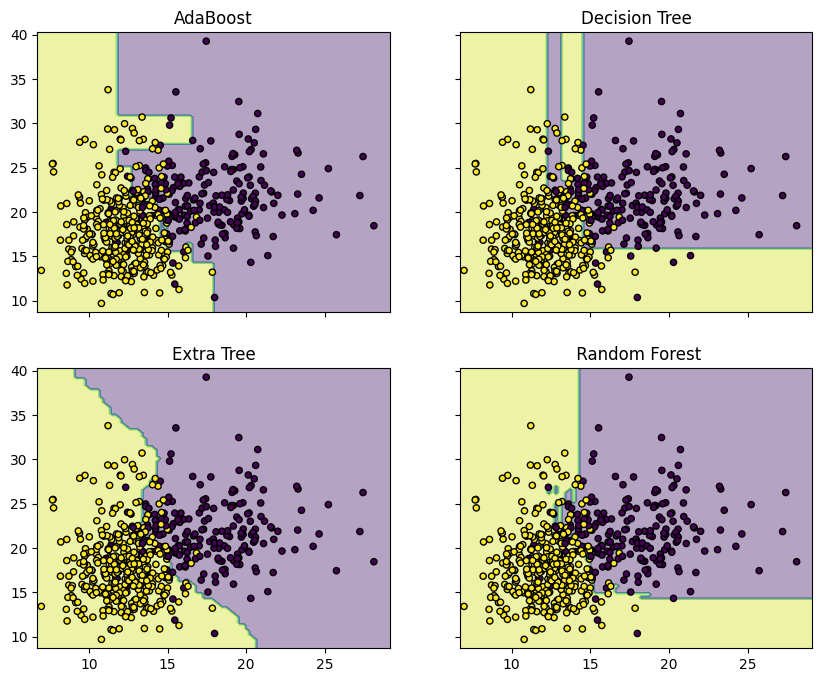

In [47]:
import matplotlib.pyplot as plt
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay


f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))
for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [ada_clf,tree_clf, extra_clf, rnd_clf ],
    ["AdaBoost", 'Decision Tree', 'Extra Tree',' Random Forest'],
):
    DecisionBoundaryDisplay.from_estimator(
        clf, X_train, alpha=0.4, ax=axarr[idx[0], idx[1]], response_method="predict"
    )
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Gradient Boosting

É semelhante ao Adaboost com a diferença de que esse método tenta se adaptar aos erros residuais cometidos pelo preditor anterior.

In [49]:
#primeiro vamos criar uma base 
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [50]:
#agora vamos treina rum DecisionTree Regressor nela

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

O truque agora é treinar o resultado **nos resíduos** do modelo anterior. 

In [51]:
y2 = y - tree_reg1.predict(X) # ea diferença entre o valor real e o predito pela árvore 1: faz uma outra árvore nesse erro
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [52]:
#repete o mesmo procedimento
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [53]:
X_new = np.array([[0.8]])

In [54]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [55]:
y_pred

array([0.75026781])

In [56]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

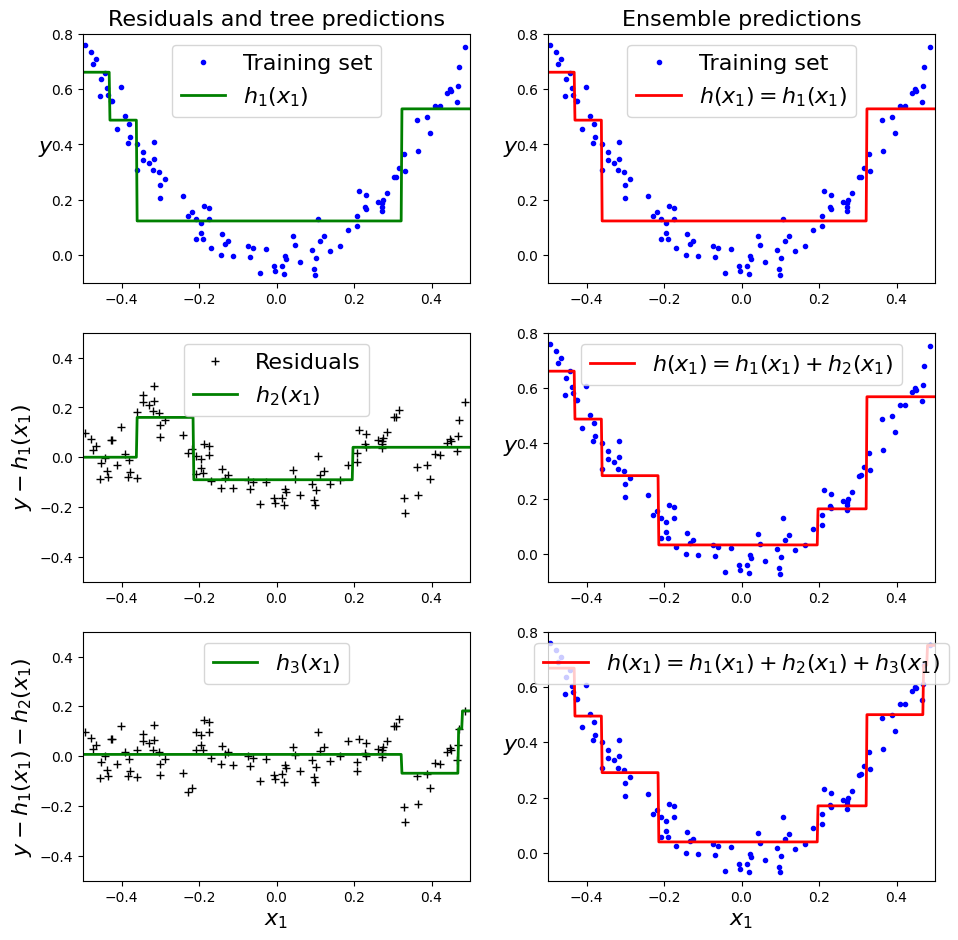

In [58]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

Fica fácil notar, pelos gráficos da direita, que a predição do ensemble se ajusta melhor aos dados que do classificador inicial. Vamos automatizar esse processo usando o gradiend boosting regressor.

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [64]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

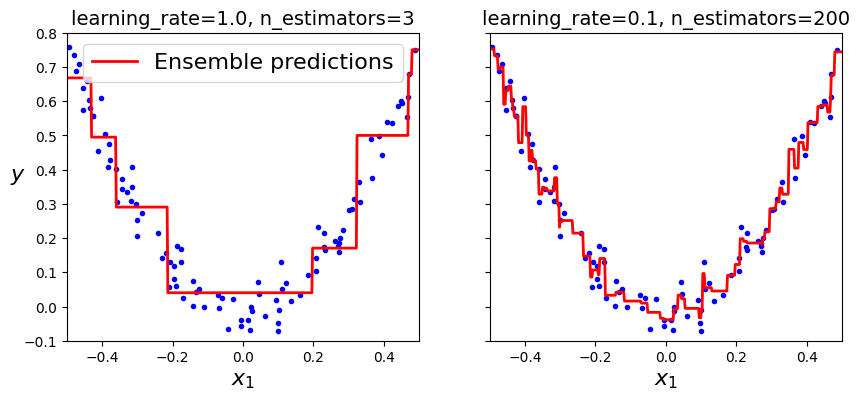

In [65]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()